Final Project- 
AIM: To simulate safe navigation of the robot

Steps:
1. Make a custom grid
2. Give Start and Goal pose
3. Perform Astar algorithms to get the global path planning
4. Get the trajectory of poses(x,y,theta) using x,y values from astar path planning
5. Implement the DWA (local planner + tracker) to track the robot
6. Add collison avoidance by the help of Lidar sensor on the robot to avoid any dynamic obstacle

In [36]:
import numpy as np
import time
import toml
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from IPython.display import Image
import cv2
from PIL import Image
%matplotlib inline

Make a custom grid and add obstacle

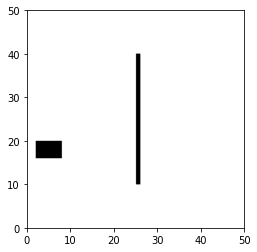

In [37]:
#custom grid
#choose resolution and dimensions
grid_res = 0.05
grid_span =  50 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[25, 26, 10, 40],
                       [2, 8, 16, 20]]) 
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )

Eulcidean function for calculating distance between two points

In [40]:
# write the Euclidean function that takes in the
# node x, y and compute the distance
def euclidean(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

NetwrokX initialization of Graph

In [41]:
#initialize graph
grid_size=grid_shape
G=nx.grid_2d_graph(*grid_size)

deleted_nodes = 0 # counter to keep track of deleted nodes
#loop to remove nodes
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
     if grid_data[i,j]==1:
        G.remove_node((i,j))
        deleted_nodes+=1
print(f"removed {deleted_nodes} nodes")
print(f"number of occupied cells in grid {np.sum(grid_data)}")

removed 21600 nodes
number of occupied cells in grid 21600.0


Give Start and Goal pose as needed[User should input this]

In [42]:
start_pose=(5/grid_res,10/grid_res)
goal_pose=(5/grid_res,25/grid_res)

Astar implementation in NetworkX

In [43]:
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, "cost")
astar_path = nx.astar_path(G, start_pose, goal_pose, heuristic=euclidean, weight="cost")

In [ ]:
astar_path

Plotting the astar path on the grid

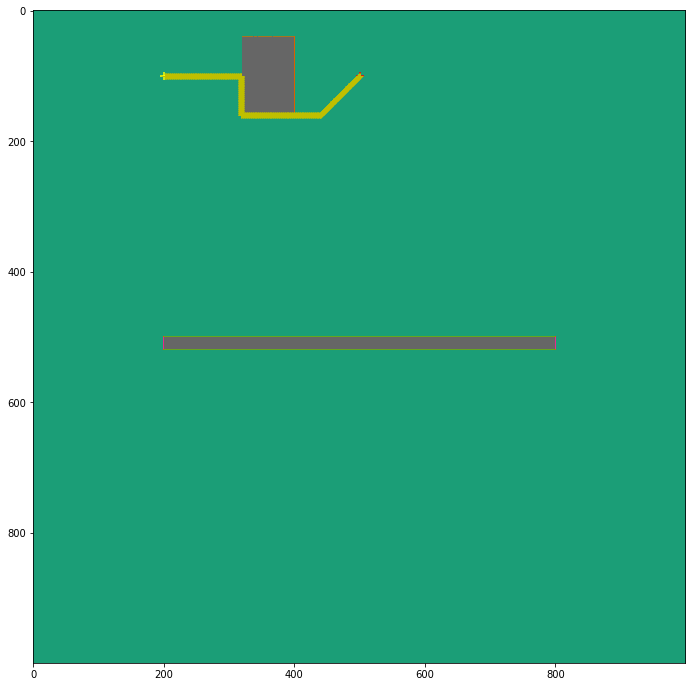

In [45]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.Dark2)
ax.scatter(start_pose[1],start_pose[0], marker = "+", color = "yellow", s = 50)
ax.scatter(goal_pose[1],goal_pose[0], marker = "+", color = "red", s = 50)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'y+')

Converting the (x,y) from astar to route commands 

In [46]:
commands=[]
cor=1

for i in range (len(astar_path)-2):
  x1,y1=astar_path[i]
  x2,y2=astar_path[i+1]
  x3,y3=astar_path[i+2]
  eval = cor*((x1-x2)*(y3-y2)-(x3-x2)*(y2-y1))
  if (eval != 0):
        cor*=-1
        if eval >0:
            ## left turn +90
            commands.append(("turn",90))
        else:
            commands.append(("turn",-90))
  else:
        commands.append(("straight",euclidean( (x2,y2), (x1,y1)) ))
print(commands)      

[('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight'

Converting the route command into trajectory of poses(x,y,theta) and smooth planning with the help of cubic spiral fucntion varitaion of theta

In [47]:
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 8

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant for desired turn radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (start_pose[0], start_pose[1], np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return np.vstack([x, y, t])

Plotting the final trajectory poses

[1.57079633 1.57079633 1.57079633 ... 1.88220784 1.65780837 1.57079633]


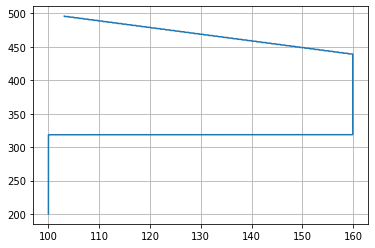

In [48]:
x, y, t = generate_trajectory(commands)
plt.figure()
plt.plot(x, y)
plt.grid()
print(t)

In [49]:
ref_path=generate_trajectory(commands)
print(ref_path)

[[100.         100.         100.         ... 103.12476125 103.11607102
  103.11607102]
 [200.         200.11111111 200.22222222 ... 495.57867777 495.67829946
  495.77829946]
 [  1.57079633   1.57079633   1.57079633 ...   1.88220784   1.65780837
    1.57079633]]


Configuring the parameters for DWA implementation

In [50]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1 1.2


In [51]:
v_min, v_max = 0.0, 0.2
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=11)
ws = np.linspace(w_min, w_max, num=11)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
print(vs)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


Making circles to resemble the robot footprint

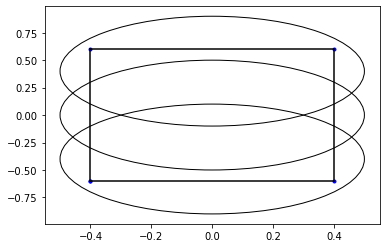

In [52]:
w=0.8
l=1.2
mule_extents = np.array([[-w/2,-l/2],
                         [w/2, -l/2],
                         [w/2, l/2],
                         [-w/2, l/2],
                         [-w/2,-l/2]])

                        
r = 0.5
l = 0.4
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

plt.figure()
#plot rectangle or just the 4 vertices
for vertex in mule_extents:
    p, q = vertex
    plt.plot(p, q, 'b.')
for v1, v2 in zip(mule_extents[:-1],mule_extents[1:]):
    p1, q1 = v1
    p2, q2 = v2
    plt.plot((p1, p2), (q1,q2), 'k-')
   
ax = plt.gca()
for x,y,rad in circles:
    ax.add_patch(plt.Circle((x,y), rad, fill=False))

Circle collision check function

In [53]:
grid_res = 0.05
def circle_collision_check(grid_data, local_traj):
    xmax, ymax = grid_shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)
        rc_pix = (rc/ grid_res)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
        occupied_pt = grid_data[X, Y] == 1
        if np.sum(np.multiply( inside_circle, occupied_pt)):
          return True
    return False

Lidar sensors class definition

In [54]:
class Lidar(object):
    def __init__(self, nbeams=7, fov=60, max_dist=5.0, sampling_pts=20):
        #nbeams = number of sensing beams
        #FOV = field-of-view of Lidar/ coverage in degrees
        #max_dist = maximum distance Lidar can sense
        #sampling_pts = num pts on a given beam for obstacle check
        self.beam_angles = np.deg2rad(np.linspace(-fov/2+np.pi/2,fov/2+np.pi/2,num=nbeams))
        self.line_sampler = max_dist * np.linspace(0, 1, num=sampling_pts)
    
    def set_env(self, grid, grid_res=0.05):
        #2-D occupancy grid and grid_resolution
        self.grid = grid_data
        self.grid_res = grid_res
    
    def sense_obstacles(self, pose):
        xc, yc, theta = pose[-1][0], pose[-1][1], pose[-1][2]
        beam_data = []
        for b in self.beam_angles:
            direction = np.array([np.cos(theta+b), np.sin(theta+b)])
            for d in self.line_sampler:
                beam_x, beam_y = np.array([xc, yc]) + d * direction
                i, j = int(beam_x), int(beam_y)
                if self.grid[i][j] == 1:
                    break
            beam_data.append(d)
        return beam_data

DWA fucntions definiton

In [60]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose[-1][0], pose[-1][1], pose[-1][2]
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        # Keep theta bounded between [-pi, pi]
        t = np.arctan2(np.sin(t), np.cos(t))
        poses.append([x,y,t])
    return np.array(poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)
    v_min = max(0, v - ACC_MAX*dt)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    epsilon = 1e-6
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
    
    #calculate kappa for the set of commands
    kappa = commands[:,1]/(commands[:,0]+epsilon)
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose,v, w, pred_horizon) #Number of steps = prediction horizon
        
        w_obs=0
        #if circle_collision_check(grid_data, local_path): #ignore colliding paths
        #    print("local path has a collision")
        #    continue
        #lidar = Lidar(max_dist=5)
        #lidar.set_env(grid_data)
        #dist = lidar.sense_obstacles(pose=pose)
        #print(f"Beam distances are {dist}")
        #for i in range(len(dist)):
        #  if dist[i]<5.0:
        #    w_obs=100
        #  else:
        #    w_obs=0
             

        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
        
        cte = euclidean(local_path[-1][:2], ref_path[-1][:2])
        
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2  + w_obs
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, (v, w)

    if best_command:
        return best_command
    else:
        return [0, 0]

Function call for DWA

In [61]:
ref_path=generate_trajectory(commands)
print(ref_path)
pred_horizon=2
start_pose_ = np.array([start_pose[0],start_pose[1], np.pi/2])
ref_path = ref_path.T
pose = []
pose.append(start_pose_)
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    if np.sqrt((local_ref_path[-1][0]-pose[-1][0])**2 + (local_ref_path[-1][1]-pose[-1][1])**2) < goal_threshold*100:
      path_index += pred_horizon
    

    # get next command
    v, w = track(local_ref_path, pose, v, w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose, v, w)

    print(pose)
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")

Streaming output truncated to the last 5000 lines.
[[100.         284.18         1.57079633]]
idx:890, v:1.200, w:0.000, time:11.0ms
[[100.         284.3          1.57079633]]
idx:892, v:1.200, w:0.000, time:12.1ms
[[100.         284.42         1.57079633]]
idx:892, v:1.200, w:0.000, time:9.3ms
[[100.         284.54         1.57079633]]
idx:894, v:1.200, w:0.000, time:9.7ms
[[100.         284.66         1.57079633]]
idx:894, v:1.200, w:0.000, time:9.8ms
[[100.         284.78         1.57079633]]
idx:896, v:1.200, w:0.000, time:9.8ms
[[100.         284.9          1.57079633]]
idx:898, v:1.200, w:0.000, time:10.4ms
[[100.         285.02         1.57079633]]
idx:898, v:1.200, w:0.000, time:9.5ms
[[100.         285.14         1.57079633]]
idx:900, v:1.200, w:0.000, time:10.7ms
[[100.         285.26         1.57079633]]
idx:902, v:1.200, w:0.000, time:10.7ms
[[100.         285.38         1.57079633]]
idx:902, v:1.200, w:0.000, time:12.3ms
[[100.         285.5          1.57079633]]
idx:904, 

In [ ]:
poses

array([[array([100.        , 200.005     ,   1.54079633]), 0.05,
        -0.30000000000000004],
       [array([100.00029996, 200.0149955 ,   1.48079633]), 0.1,
        -0.6000000000000001],
       [array([100.00164813, 200.02993479,   1.39079633]),
        0.15000000000000002, -0.9000000000000001],
       ...,
       [array([  101.61718215,   237.07049644, -2922.60920367]),
        1.166995456, -1.0],
       [array([  101.68662336,   236.97776516, -2922.70920367]),
        1.158497728, -1.0],
       [array([  101.74624051,   236.87892843, -2922.80920367]),
        1.154248864, -1.0]], dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


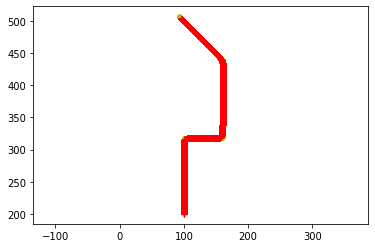

In [63]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='y')
for s in range(len(poses[:,0])):
  plt.plot(poses[:,0][s][0],poses[:,0][s][1],'r+')
  
plt.show()  

Plotting the tracking of robot path

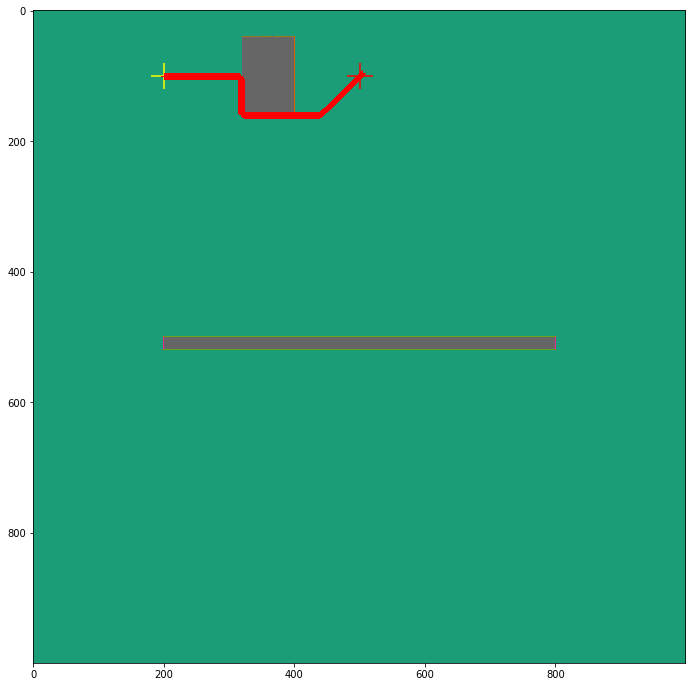

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.Dark2)
ax.scatter(start_pose[1],start_pose[0], marker = "+", color = "yellow", s = 700)
ax.scatter(goal_pose[1],goal_pose[0], marker = "+", color = "red", s = 700)
for s in range(len(poses[:,0])):
  ax.plot(poses[:,0][s][1],poses[:,0][s][0],'r+')